In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first().date
print(f"The most recent date in the dataset is: {recent_date}")

The most recent date in the dataset is: 2017-08-23


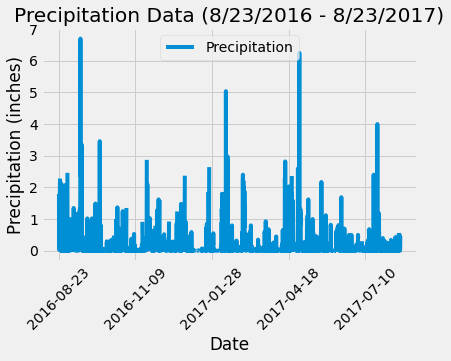

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
one_year = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores
data_precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year).all()
data_precip
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(data_precip, columns=["Date", "Precipitation"]).set_index("Date")

# Sort the dataframe by date
precip_df = precip_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Precipitation Data (8/23/2016 - 8/23/2017)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
no_stations = session.query(Station).count()
print(f"Number of stations: {no_stations}")

Number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
active_stations_df = pd.DataFrame(active_stations, columns=["Station ID", "Number of Rows"])
active_stations_df

,Station ID,Number of Rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
precip_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station == "USC00519281").all()
precip_data_df = pd.DataFrame(precip_data, columns=["Lowest Temp", "Highest Temp", "Average Temp"])
precip_data_df

,Lowest Temp,Highest Temp,Average Temp
0,54.0,85.0,71.663781


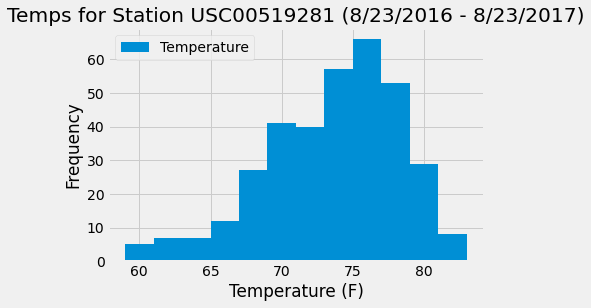

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year).\
            filter(Measurement.station == "USC00519281").all()

last_year_df = pd.DataFrame(last_year, columns=["Date", "Temperature"])

last_year_df.plot.hist(bins=12, title="Temps for Station USC00519281 (8/23/2016 - 8/23/2017)")
plt.xlabel("Temperature (F)")
plt.show()

In [16]:
session.close()

## Bonus: Temperature Analysis I

In [17]:
# "tobs" is "temperature observations"
df = pd.read_csv('Resources/hawaii_measurements.csv')
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [18]:
# Convert the date column format from string to datetime
df["date"] = pd.to_datetime(df["date"])

In [20]:
# Set the date column as the DataFrame index
df_index = df.set_index("date")
df_index.head()

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65
2010-01-02,USC00519397,0.00,63
2010-01-03,USC00519397,0.00,74
2010-01-04,USC00519397,0.00,76
2010-01-06,USC00519397,NaN,73


### Compare June and December data across all years 

In [21]:
from scipy import stats

In [22]:
# Filter data for desired months
june = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date.like("%-06-%")).all()
june_df = pd.DataFrame(june)
june_df["tobs"] = june_df["tobs"].astype(int)

december = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date.like("%-12-%")).all()
december_df = pd.DataFrame(december)
december_df["tobs"] = december_df["tobs"].astype(int)

In [23]:
# Identify the average temperature for June
avg_june_temp = round(june_df["tobs"].mean(), 3)
print(f"The avereage temperature for june is {avg_june_temp} degrees")

The avereage temperature for june is 74.944 degrees


In [24]:
# Identify the average temperature for December
avg_dec_temp = round(december_df["tobs"].mean(), 3)
print(f"The avereage temperature for june is {avg_dec_temp} degrees")

The avereage temperature for june is 71.042 degrees


In [25]:
# Create collections of temperature data
june_temp = june_df["tobs"].to_list()

december_temp = december_df["tobs"].to_list()

In [26]:
# Run paired t-test
stats.ttest_ind(june_temp, december_temp)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### Analysis
The t-value is very large and the pvalue is fairly small, so the average temperatures for June and December are statistically different from eachother.

## Bonus Challenge Assignment: Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
calc_temps_year = calc_temps("2016-08-23", "2017-08-23")
calc_temps_year

[(58.0, 74.59058295964125, 87.0)]

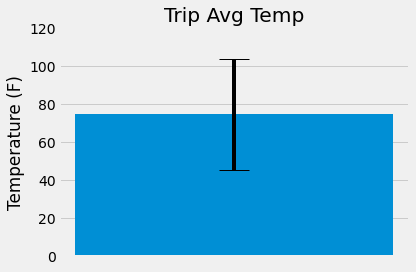

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1,calc_temps_year[0][1], yerr=calc_temps_year[0][2]-calc_temps_year[0][0], capsize=15)
plt.title("Trip Avg Temp")
plt.ylim(0, 120, 10)
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_station = pd.read_sql('''select s.station, s.name, s.latitude, s.longitude, s.elevation, sum(m.prcp) as rainfall_year
                              from Station s
                              join Measurement m on s.station=m.station
                              where m.date between '2016-08-23' and '2017-08-23' 
                              group by s.station
                              order by rainfall_year desc''', conn)
rain_station

,station,name,latitude,longitude,elevation,rainfall_year
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.81
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,70.03
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


In [32]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
days = ('08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07')

normals = []
for day in days:
    normals.append(daily_normals(day)[0])
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [34]:
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
range_dates = pd.date_range(start=start_date, end=end_date)

# Strip off the year and save a list of strings in the format %m-%d
dates = []
for days in range_dates:
    day = dt.datetime.strftime(days, '%m-%d')
    dates.append(day)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in dates:
    normals.append(daily_normals(date)[0])
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
daily_normals_df["Trip Dates"] = dates
daily_normals_df = daily_normals_df.set_index("Trip Dates")
daily_normals_df

,tmin,tavg,tmax
Trip Dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


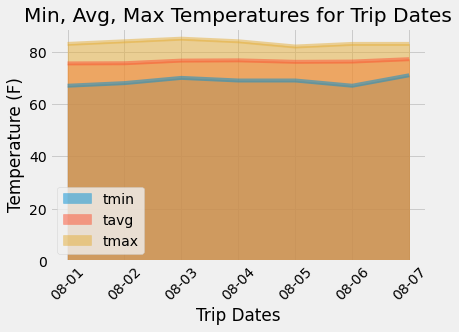

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False, title="Min, Avg, Max Temperatures for Trip Dates")
plt.xticks(rotation=45)
plt.ylabel("Temperature (F)")
plt.show()

## Close Session

In [37]:
session.close()